# Performing z-mu cosmology fitting

In [1]:
import cosmographi as cg
import caskade as ck
import jax.numpy as jnp
import jax
from functools import partial
import matplotlib.pyplot as plt
from time import time

print(jax.config.jax_enable_x64)

True


## Making a SN sample

In [2]:
# Define the simulator
z_max = 2.0
cosmology = cg.Cosmology()
rateIa = cg.sn.SNRateConst(cosmology, 1e-4, z_min=0.0, z_max=z_max, name="rateIa")
rateIbc = cg.sn.SNRateConst(cosmology, 5e-5, z_min=0.0, z_max=z_max, name="rateIbc")
ratecombined = cg.sn.CombinedSNRate((rateIa, rateIbc), z_min=0.0, z_max=z_max, cosmology=cosmology)
# detect_Ia = cg.sn.MuNCDFDetect(threshold=15, scale=0.1 * jnp.sqrt(8 / jnp.pi), name="detectIa")
# detect_Ibc = cg.sn.MuNCDFDetect(threshold=14, scale=0.13 * jnp.sqrt(8 / jnp.pi), name="detectIbc")
detect_Ia = cg.sn.MuSigmoidDetect(threshold=15, scale=0.1, name="detectIa")
detect_Ibc = cg.sn.MuSigmoidDetect(threshold=14, scale=0.13, name="detectIbc")

# Define sampling parameters
n_samples = 1000
var_z_Ia = lambda z: 0.05**2 * jnp.ones_like(z)
var_mu_Ia = lambda z: 0.1**2 * jnp.ones_like(z)
cov_Ia = lambda key, var_z, var_mu: jnp.zeros(
    var_mu.shape
)  # jax.random.uniform(key, var_m.shape, minval=0, maxval=jnp.sqrt(var_m * var_z) * 0.7)
var_z_Ibc = lambda z: 0.2**2 * jnp.ones_like(z)
var_mu_Ibc = lambda z: 1.0**2 * jnp.ones_like(z)
cov_Ibc = lambda key, var_z, var_mu: jnp.zeros(
    var_mu.shape
)  # jax.random.uniform(key, var_m.shape, minval=0, maxval=jnp.sqrt(var_m * var_z) * 0.7)

# Sample SN
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
# sample SN redshifts
z = ratecombined.sample(subkey, n_samples)
# sample SN types
t = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    t.append(ratecombined.sample_type(subkey, z[i]))
t = jnp.array(t)
# compute true distance modulus
DL = jax.vmap(cosmology.luminosity_distance)(z)
mu = 5 * jnp.log10(DL) - 5
# determine observational uncertainties
var_z = jnp.stack((var_z_Ia(z), var_z_Ibc(z)), axis=-1)  # (N, t)
var_mu = jnp.stack((var_mu_Ia(z), var_mu_Ibc(z)), axis=-1)  # (N, t)
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
cov = jnp.stack(
    (cov_Ia(subkey1, var_mu[:, 0], var_z[:, 0]), cov_Ibc(subkey2, var_mu[:, 1], var_z[:, 1])),
    axis=-1,
)  # (N, t)
# sample observed apparent magnitudes
key, subkey = jax.random.split(key)
samp_varz = jnp.where(t == 0, var_z[:, 0], var_z[:, 1])
samp_varmu = jnp.where(t == 0, var_mu[:, 0], var_mu[:, 1])
samp_cov = jnp.where(t == 0, cov[:, 0], cov[:, 1])
obs = jax.random.multivariate_normal(
    key,
    mean=jnp.stack((z, mu), axis=-1),
    cov=jnp.stack(
        (jnp.stack((samp_varz, samp_cov), axis=-1), jnp.stack((samp_cov, samp_varmu), axis=-1)),
        axis=-1,
    ),
)
z_obs = obs[:, 0]
mu_obs = obs[:, 1]
obs_mean = obs  # (N, 2)
obs_cov = jnp.stack(
    (
        jnp.stack((var_z, cov), axis=-1),
        jnp.stack((cov, var_mu), axis=-1),
    ),
    axis=-1,
)  # (N, t, 2, 2)
# sample detections
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
detected = jnp.where(
    t == 0, detect_Ia.sample(subkey1, z, mu_obs), detect_Ibc.sample(subkey2, z, mu_obs)
)

# Keep only detected SNe
obs_meanD = obs_mean[detected]
obs_covD = obs_cov[detected]

Number of detected SNe: 424 / 1000


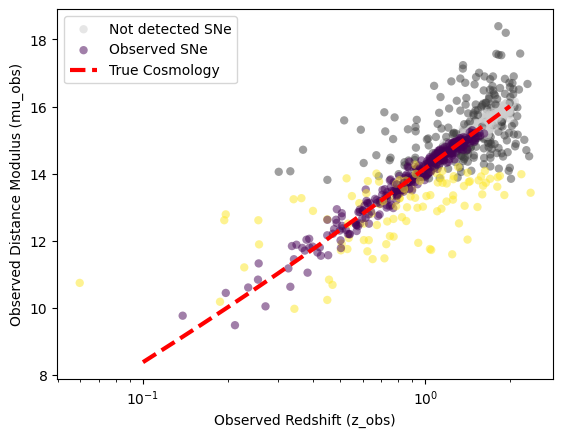

In [3]:
print(f"Number of detected SNe: {jnp.sum(detected)} / {n_samples}")
plt.scatter(
    z_obs[~detected],
    mu_obs[~detected],
    c=plt.get_cmap("Greys")(0.5 * t[~detected] + 0.3),
    alpha=0.5,
    label="Not detected SNe",
    linewidth=0,
)
plt.scatter(
    z_obs[detected],
    mu_obs[detected],
    c=t[detected],
    cmap="viridis",
    alpha=0.5,
    label="Observed SNe",
    linewidth=0,
)
z_line = jnp.linspace(0.1, z_max, 1000)
mu_base = 5 * jnp.log10(jax.vmap(cosmology.luminosity_distance)(z_line)) - 5
plt.plot(
    z_line,
    mu_base,
    "r--",
    label="True Cosmology",
    linewidth=3,
)
plt.xlabel("Observed Redshift (z_obs)")
plt.xscale("log")
plt.ylabel("Observed Distance Modulus (mu_obs)")
plt.legend()
plt.show()

## Construct posterior density

In [4]:
cosmo_mean = jnp.array([0.307, -1])  # Omega_m, w
cosmo_cov = jnp.array([[0.1, 0], [0, 1.0]])
cosmology.Omega_m.to_dynamic()
cosmology.w0.to_dynamic()

detect_Ia_mean = jnp.array([-4, 0.1])  # threshold, scale
detect_Ia_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ia.threshold.to_dynamic()
# detect_Ia.scale.to_dynamic()

detect_Ibc_mean = jnp.array([-4.1, 0.1])  # threshold, scale
detect_Ibc_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ibc.threshold.to_dynamic()
# detect_Ibc.scale.to_dynamic()

In [5]:
# class Likelihood(ck.Module):
#     def __init__(
#         self,
#         cosmology: cg.Cosmology,
#         ratecombined: cg.sn.CombinedSNRate,
#         detect: list[cg.sn.mSigmoidDetect],
#         name=None,
#     ):
#         super().__init__(name=name)
#         self.cosmology = cosmology
#         self.rate = ratecombined
#         self.detect = detect
#         self.vZ = jax.vmap(self.logP_mu_theta, in_axes=(0, None, None, None))
#         self.vzt = jax.vmap(self._log_likelihood_zt, in_axes=(0, None, None))
#         self.vsll = jax.vmap(
#             lambda _xy, _i, _z, _t: self.logP_mu_theta(_xy, _i, z=_z, t=_t),
#             in_axes=(0, None, None, None),
#         )

#     @ck.forward
#     def Z_zmu_theta(self, i, z, t):
#         mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z)) - 5
#         sigma = jnp.sqrt(obs_covD[i][t][1, 1])
#         mu_obs_ = cg.utils.midpoints(mu - 5 * sigma, mu + 5 * sigma, 25)
#         dA = mu_obs_[1] - mu_obs_[0]
#         return jax.nn.logsumexp(self.vsll(mu_obs_, i, z, t)) + jnp.log(dA)
#         # return cg.utils.log_gauss_rescale_integrate(
#         #     self.vZ,
#         #     mu - 5 * sigma,
#         #     mu + 5 * sigma,
#         #     mu,
#         #     2 * sigma,
#         #     n=25,
#         #     args=(i, z, t),
#         # )

#     @ck.forward
#     def logP_mu_theta(self, mu_obs_, i, z, t):
#         mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z)) - 5
#         # P(z_obs, mu_obs | z, M, t, Omega)
#         po = -0.5 * (jnp.log(obs_covD[i][t][1, 1]) + ((mu_obs_ - mu) ** 2) / obs_covD[i][t][1, 1])
#         # P(d=1 | mu_obs, z, t)
#         pd = self.detect[t].log_prob(z, mu_obs_)
#         return po + pd

#     @ck.forward
#     def logP_zmu_theta(self, i, z, t):
#         mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z)) - 5
#         zmu = jnp.array((z, mu))
#         # P(z_obs, mu_obs | z, t, Omega)
#         r = obs_meanD[i] - zmu
#         po = -0.5 * (
#             jnp.linalg.slogdet(obs_covD[i][t])[1] + jnp.dot(r, jnp.linalg.solve(obs_covD[i][t], r))
#         )
#         # P(d=1 | mu_obs, z, t)
#         pd = self.detect[t].log_prob(z, obs_meanD[i][1])
#         return po + pd

#     @ck.forward
#     def _log_likelihood_zt(self, z, i, t):
#         # int t
#         ll = self.rate.logPz(z)
#         ll = ll + self.rate.logPt_z(t, z)
#         ll = ll + self.logP_zmu_theta(i, z, t) - self.Z_zmu_theta(i, z, t)
#         return ll

#     @ck.forward
#     def _log_likelihood(self, i):
#         # int z
#         log_like = []
#         for t in range(len(self.detect)):
#             sigma = jnp.sqrt(obs_covD[i][t][0, 0])
#             a = jnp.clip(
#                 jnp.clip(obs_meanD[i][0], a_min=0, a_max=self.rate.z_max) - 5 * sigma,
#                 a_min=0,
#                 a_max=self.rate.z_max,
#             )
#             b = jnp.clip(
#                 jnp.clip(obs_meanD[i][0], a_min=0, a_max=self.rate.z_max) + 5 * sigma,
#                 a_min=0,
#                 a_max=self.rate.z_max,
#             )
#             z = cg.utils.midpoints(a, b, 100)

#             # z = cg.utils.midpoints(
#             #     jnp.clip(obs_mean[i][0] - 5 * sigma, a_min=0),
#             #     jnp.clip(obs_mean[i][0] + 5 * sigma, a_max=self.rate.z_max),
#             #     100,
#             # )
#             ll = jax.vmap(self._log_likelihood_zt, in_axes=(0, None, None))(z, i, t)
#             ll = jax.nn.logsumexp(ll) + jnp.log(z[1] - z[0])
#             # vll = jax.vmap(partial(self._log_likelihood_zt, i, t=t))
#             # a = jnp.clip(obs_mean[i][0] - 5 * sigma, a_min=0)
#             # b = jnp.clip(obs_mean[i][0] + 5 * sigma, a_max=self.rate.z_max)
#             # ll = cg.utils.log_gauss_rescale_integrate(
#             #     self.vzt, a, b, obs_mean[i][0], sigma, n=100, args=(i, t)
#             # )
#             log_like.append(ll)
#         return jax.nn.logsumexp(jnp.array(log_like))

#     @ck.forward
#     def log_likelihood(self):
#         return jax.vmap(self._log_likelihood)(jnp.arange(len(obs_meanD))).sum()


class Prior(ck.Module):
    def __init__(self, cosmology, detect, name=None):
        super().__init__(name=name)
        self.cosmology = cosmology
        self.detect = detect

    @ck.forward
    def log_prior(self):
        prior = 0
        # Cosmology prior
        params = jnp.array([self.cosmology.Omega_m.value, self.cosmology.w0.value])
        # diff = params - jnp.array(cosmo_mean)
        # exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(cosmo_cov, diff))
        # norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(cosmo_cov)[1])
        # prior = prior + norm + exponent
        prior = jnp.where(
            (params[0] <= 0) | (params[0] >= 1), -jnp.inf, prior
        )  # exclude unphysical Omega_m

        # Detect_Ia prior
        params = jnp.array([self.detect[0].threshold.value, self.detect[0].scale.value])
        diff = params - jnp.array(detect_Ia_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ia_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ia_cov)[1])
        prior = prior + norm + exponent

        # Detect_Ibc prior
        params = jnp.array([self.detect[1].threshold.value, self.detect[1].scale.value])
        diff = params - jnp.array(detect_Ibc_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ibc_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ibc_cov)[1])
        prior = prior + norm + exponent
        return prior


class Posterior(ck.Module):
    def __init__(self, likelihood, prior, name=None):
        super().__init__(name=name)
        self.likelihood = likelihood
        self.prior = prior

    @ck.forward
    def log_posterior(self):
        log_prior = self.prior.log_prior()
        log_likelihood = self.likelihood.log_likelihood()
        return log_prior + log_likelihood

In [6]:
posterior = Posterior(
    likelihood=cg.sn.ZMuLikelihood(
        cosmology,
        ratecombined=ratecombined,
        detect=[detect_Ia, detect_Ibc],
        mean=obs_meanD,
        cov=obs_covD,
        name=f"likelihood",
    ),
    prior=Prior(cosmology, [detect_Ia, detect_Ibc]),
)

start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)

print(posterior)

-660.5692781209314
Time taken (s): 10.08932876586914
-660.5692781209314
Time taken (s): 0.8553411960601807
-660.5692781209314
Time taken (s): 0.8368988037109375
-660.5692781209314
Time taken (s): 0.8401026725769043
Posterior|Posterior
    likelihood|ZMuLikelihood
        Cosmology|Cosmology
            H0|static: 67.9
            Omega_m|dynamic value: 0.307
            Omega_k|static: 0
            Omega_r|static: 0
            Omega_l|pointer
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
            w0|dynamic value: -1
            wa|static: 0
        CombinedSNRate|CombinedSNRate
            Cosmology|Cosmology
                H0|static: 67.9
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
                Omega_l|pointer
                    Omega_m|dynamic value: 0.307
                    Omega_k|static: 0
                    Omega_r|static: 0
        

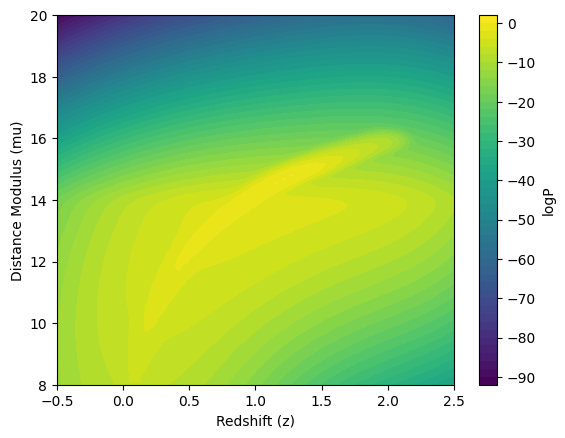

In [7]:
z_test = jnp.linspace(-0.5, 2.5, 50)
mu_test = jnp.linspace(8, 20, 100)
Z = jnp.stack(jnp.meshgrid(z_test, mu_test, indexing="ij"), axis=-1)
Lp = jax.vmap(posterior.likelihood.logP_Xd1, in_axes=(0, None, None))(
    Z.reshape(-1, 2), obs_covD[0], ()
).reshape(50, 100)
plt.contourf(z_test, mu_test, Lp.T, levels=50)
plt.colorbar(label="logP")
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (mu)")
plt.show()

In [8]:
N = 50
Om = jnp.linspace(0.01, 0.5, N)
Ow = jnp.linspace(-2, -0.25, N)
x = jnp.stack(jnp.meshgrid(Om, Ow, indexing="xy"), axis=-1)
Lp = (
    cg.utils.vmap_chunked1d(posterior.log_posterior, chunk_size=5, prog_bar=True)(x.reshape(-1, 2))
    .reshape(N, N)
    .block_until_ready()
)

100%|██████████| 500/500 [01:27<00:00,  5.69it/s]


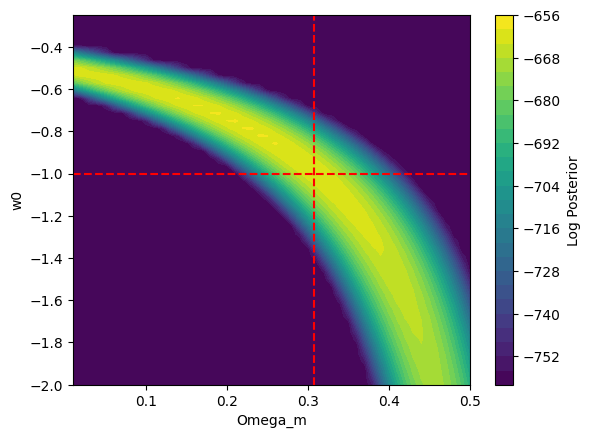

In [9]:
plt.contourf(Om, Ow, jnp.clip(Lp, a_min=jnp.max(Lp) - 100), levels=32, cmap="viridis")
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Posterior")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [10]:
print(Lp)

[[-2057.47610292 -2050.70222565 -2045.68028397 ...  -677.67576916
   -685.07563727  -694.76434876]
 [-2049.9794611  -2044.29438912 -2039.9467227  ...  -678.87263377
   -686.7847275   -696.94605311]
 [-2042.63847534 -2037.94319122 -2034.23520963 ...  -680.2529946
   -688.68432028  -699.32436735]
 ...
 [ -932.02469208  -944.3745133   -956.90527789 ... -1604.05388924
  -1617.76005481 -1631.33298871]
 [-1043.86840935 -1056.40012285 -1069.04095297 ... -1665.32828639
  -1677.27029486 -1689.08727875]
 [-1173.40514812 -1185.46408454 -1197.57093865 ... -1726.9104945
  -1737.04279264 -1747.06544191]]


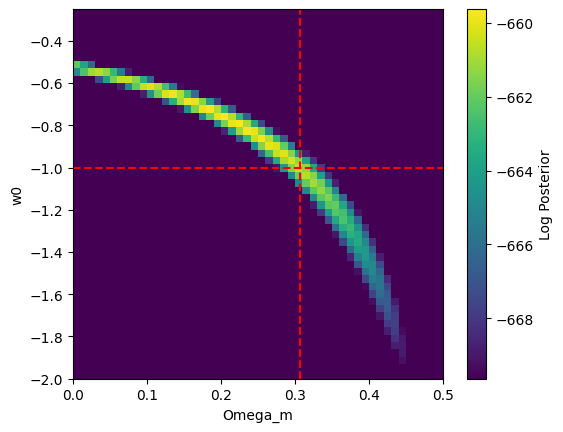

In [11]:
plt.imshow(
    Lp,
    cmap="viridis",
    vmin=jnp.max(Lp) - 10,
    origin="lower",
    extent=(0, 0.5, -2, -0.25),
    interpolation="none",
)
plt.gca().set_aspect((0.5 - 0) / (-0.25 - -2))
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Posterior")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [12]:
# raise Exception()

(2,)


MALA: 100%|██████████| 100/100 [03:41<00:00,  2.21s/it, acc_rate=0.78]


(2, 2)


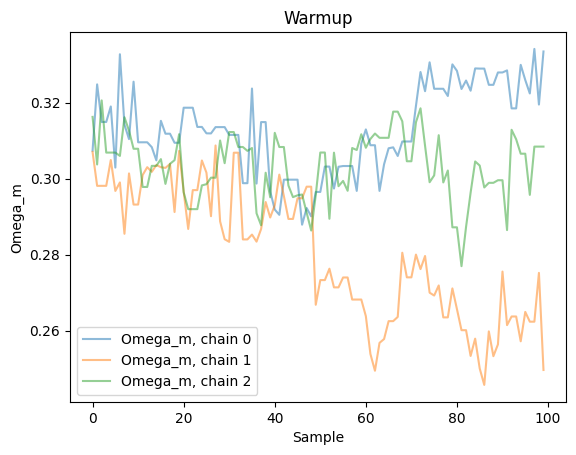

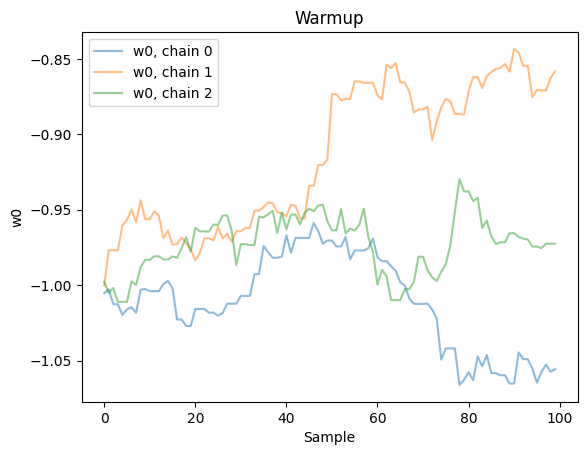

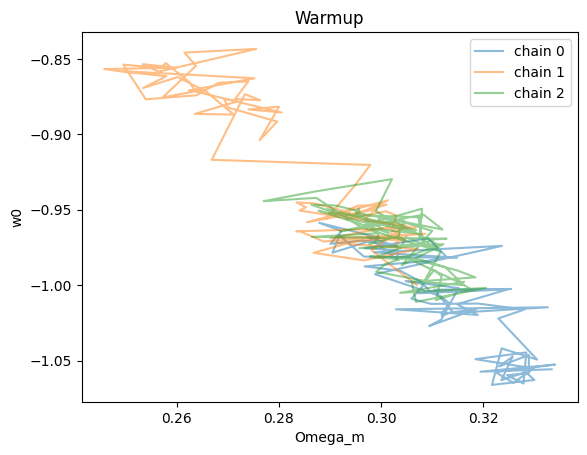

MALA: 100%|██████████| 1000/1000 [36:37<00:00,  2.20s/it, acc_rate=0.84]


In [13]:
x0 = posterior.build_params_array()
print(x0.shape)

chains = 16
key, subkey = jax.random.split(key)

# warmup
key, subkey = jax.random.split(key)
samples_burn = cg.utils.mala(
    jnp.repeat(x0[None, :], chains, axis=0),
    posterior.log_posterior,
    num_samples=100,
    epsilon=0.01,
    key=subkey,
    progress=True,
)
cov = jnp.cov(samples_burn.reshape(-1, samples_burn.shape[-1]).T)
print(cov.shape)

plt.plot(range(samples_burn.shape[0]), samples_burn[:, 0, 0], alpha=0.5, label="Omega_m, chain 0")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 1, 0], alpha=0.5, label="Omega_m, chain 1")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 2, 0], alpha=0.5, label="Omega_m, chain 2")
plt.xlabel("Sample")
plt.ylabel("Omega_m")
plt.title("Warmup")
plt.legend()
plt.show()

plt.plot(range(samples_burn.shape[0]), samples_burn[:, 0, 1], alpha=0.5, label="w0, chain 0")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 1, 1], alpha=0.5, label="w0, chain 1")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 2, 1], alpha=0.5, label="w0, chain 2")
plt.xlabel("Sample")
plt.ylabel("w0")
plt.title("Warmup")
plt.legend()
plt.show()

plt.plot(samples_burn[:, 0, 0], samples_burn[:, 0, 1], alpha=0.5, label="chain 0")
plt.plot(samples_burn[:, 1, 0], samples_burn[:, 1, 1], alpha=0.5, label="chain 1")
plt.plot(samples_burn[:, 2, 0], samples_burn[:, 2, 1], alpha=0.5, label="chain 2")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.title("Warmup")
plt.legend()
plt.show()

# production
key, subkey = jax.random.split(key)
samples_prod = cg.utils.mala(
    samples_burn[-1],
    posterior.log_posterior,
    mass_matrix=cov,
    num_samples=1000,
    epsilon=0.7,
    key=subkey,
    progress=True,
)

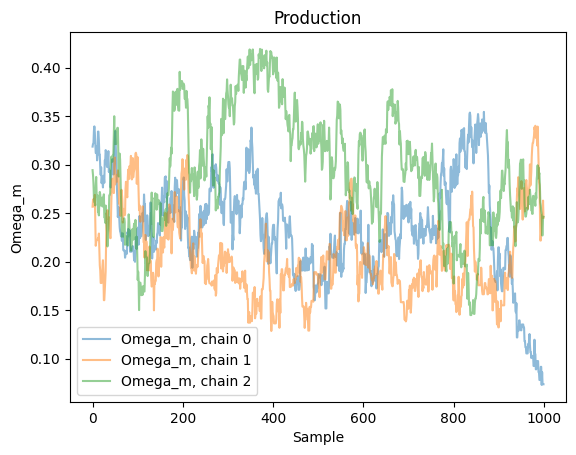

In [14]:
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 0, 0], alpha=0.5, label="Omega_m, chain 0")
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 1, 0], alpha=0.5, label="Omega_m, chain 1")
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 2, 0], alpha=0.5, label="Omega_m, chain 2")
plt.xlabel("Sample")
plt.ylabel("Omega_m")
plt.title("Production")
plt.legend()
plt.show()

In [15]:
print(posterior.dynamic_params)
print(posterior)

(Omega_m, w0)
Posterior|Posterior
    likelihood|ZMuLikelihood
        Cosmology|Cosmology
            H0|static: 67.9
            Omega_m|dynamic value: 0.307
            Omega_k|static: 0
            Omega_r|static: 0
            Omega_l|pointer
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
            w0|dynamic value: -1
            wa|static: 0
        CombinedSNRate|CombinedSNRate
            Cosmology|Cosmology
                H0|static: 67.9
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
                Omega_l|pointer
                    Omega_m|dynamic value: 0.307
                    Omega_k|static: 0
                    Omega_r|static: 0
                w0|dynamic value: -1
                wa|static: 0
            sn_rates|ntuple
                rateIa|SNRateConst
                    Cosmology|Cosmology
                        H0|static: 67.9


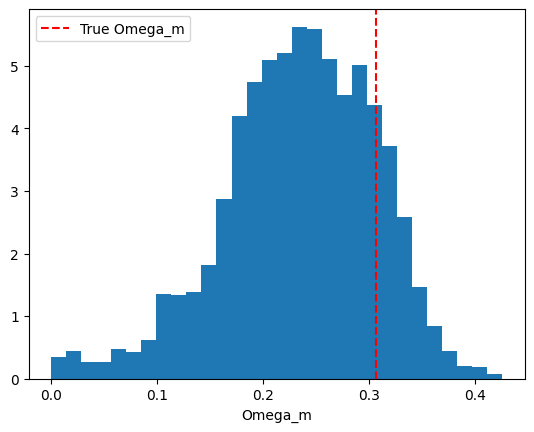

In [16]:
plt.hist(samples_prod[:, :, 0].reshape(-1), bins=30, density=True)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.xlabel("Omega_m")
plt.legend()
plt.show()

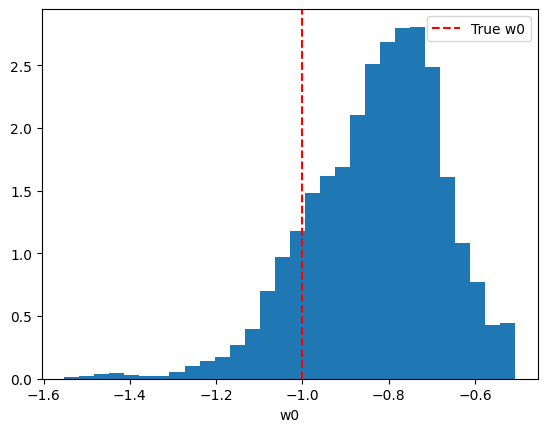

In [17]:
plt.hist(samples_prod[:, :, 1].reshape(-1), bins=30, density=True)
plt.axvline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("w0")
plt.legend()
plt.show()

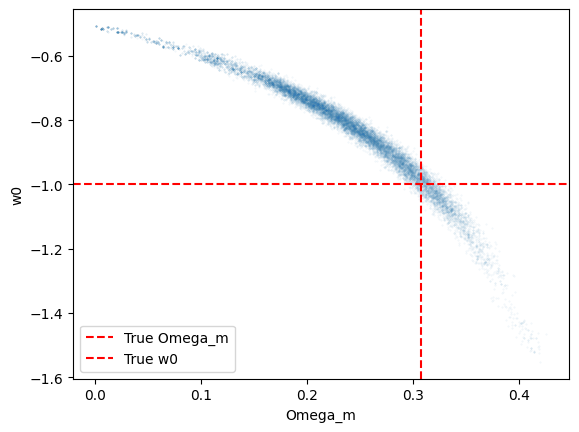

In [18]:
plt.scatter(samples_prod[:, :, 0].reshape(-1), samples_prod[:, :, 1].reshape(-1), s=0.1, alpha=0.1)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.legend()
plt.show()

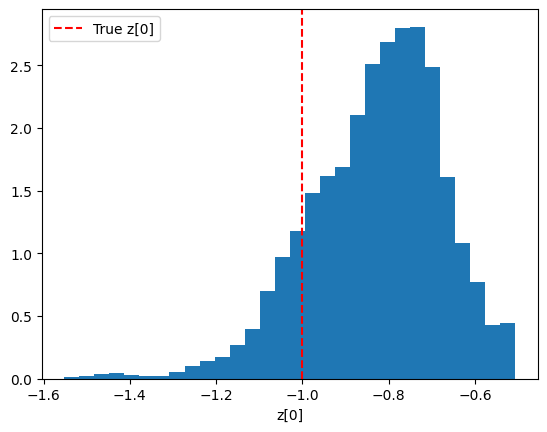

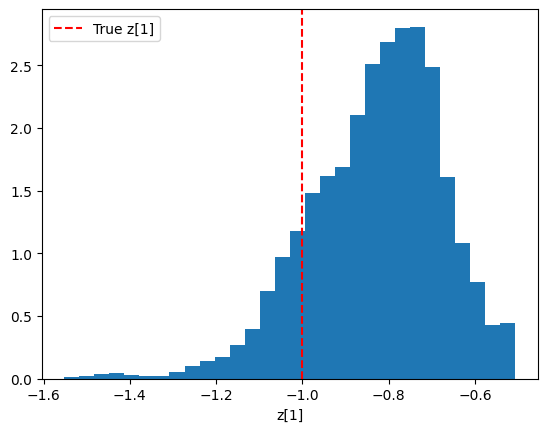

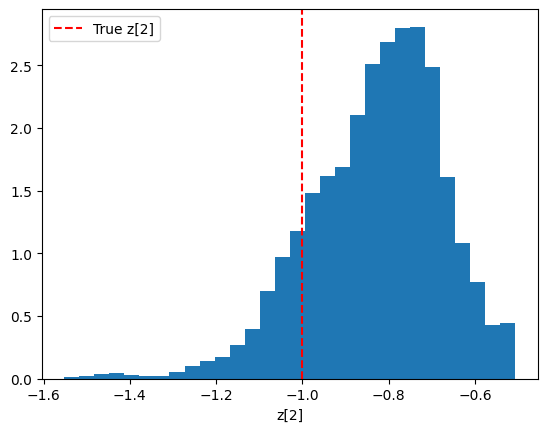

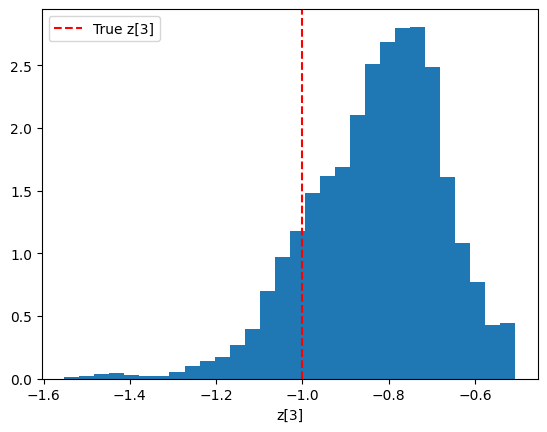

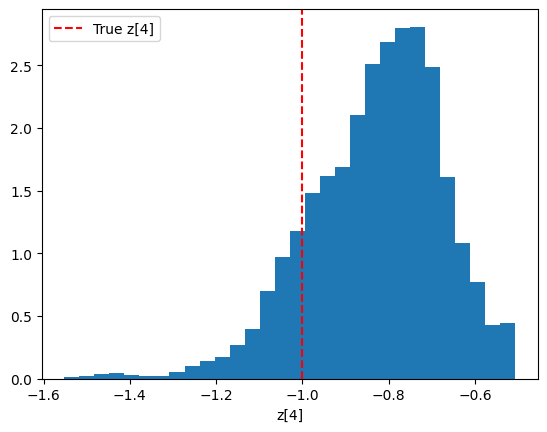

In [19]:
for i in range(5):
    plt.hist(samples_prod[:, :, 2 + i].reshape(-1), bins=30, density=True)
    plt.axvline(x0[2 + i], color="r", linestyle="--", label=f"True z[{i}]")
    plt.xlabel(f"z[{i}]")
    plt.legend()
    plt.show()

In [20]:
len(x0)

2